<a href="https://colab.research.google.com/github/ucalyptus/BS-Nets-Implementation-Pytorch/blob/master/BSNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from scipy import io 
import torch.utils.data
import scipy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [0]:
!pip install -U spectral
if not (os.path.isfile('/content/Indian_pines_corrected.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
if not (os.path.isfile('/content/Indian_pines_gt.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

Requirement already up-to-date: spectral in /usr/local/lib/python3.6/dist-packages (0.20)


In [0]:
def padWithZeros(X, margin=2):

    ## From: https://github.com/gokriznastic/HybridSN/blob/master/Hybrid-Spectral-Net.ipynb
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):

     ## From: https://github.com/gokriznastic/HybridSN/blob/master/Hybrid-Spectral-Net.ipynb
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]), dtype=np.uint8)
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]), dtype=np.uint8)
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels


In [0]:

class HyperSpectralDataset(Dataset):
    """HyperSpectral dataset."""

    def __init__(self,data_url,label_url):
        
        self.data = np.array(scipy.io.loadmat('/content/'+data_url.split('/')[-1])[data_url.split('/')[-1].split('.')[0].lower()])
        self.targets = np.array(scipy.io.loadmat('/content/'+label_url.split('/')[-1])[label_url.split('/')[-1].split('.')[0].lower()])
        self.data, self.targets = createImageCubes(self.data,self.targets, windowSize=5)
        
        self.data = self.data[:10240,:,:,:]
        self.targets = self.targets[:10240]
        self.data = torch.Tensor(self.data)
        self.data = self.data.permute(0,3,1,2)
      
      
        

    def __len__(self):
        return self.data.shape[0]
    
    
    

    def __getitem__(self, idx):
      
      return self.data[idx,:,:,:] , self.targets[idx]
        
      
      
      
      
      
        


In [0]:
data_train = HyperSpectralDataset('Indian_pines_corrected.mat','Indian_pines_gt.mat')
train_loader = DataLoader(data_train, batch_size=64, shuffle=True)

class BSNET_Conv(nn.Module):

    def __init__(self,):
      
        super(BSNET_Conv, self).__init__()
        self.conv1 = nn.Sequential(
        	nn.Conv2d(200,64,(3,3),1,0),
        	nn.ReLU(True))

        self.conv1_1 = nn.Sequential(
        	nn.Conv2d(200,128,(3,3),1,0),
        	nn.ReLU(True))
        self.conv1_2 = nn.Sequential(
        	nn.Conv2d(128,64,(3,3),1,0),
        	nn.ReLU(True))
        
        self.deconv1_2 = nn.Sequential(
        	nn.ConvTranspose2d(64,64,(3,3),1,0),
        	nn.ReLU(True))
        
        self.deconv1_1 = nn.Sequential(
        	nn.ConvTranspose2d(64,128,(3,3),1,0),
        	nn.ReLU(True))

        self.conv2_1 = nn.Sequential(
        	nn.Conv2d(128,200,(1,1),1,0),
        	nn.Sigmoid())
        

        self.fc1 = nn.Sequential(
        	nn.Linear(64,128),
        	nn.ReLU(True))
        self.fc2 = nn.Sequential(
        	nn.Linear(128,200),
        	nn.Sigmoid())
    
            
    def GlobalPool(self,feature_size):
        
      
        return nn.AvgPool2d(kernel_size=feature_size)
        
    
    def BAM(self,x):
            
        x = self.conv1(x)
        #print(x.shape)
        
        #x = torch.topk(x, k=1, dim=2)[0]
        #x = torch.topk(x, k=1, dim=3)[0]
        gp = self.GlobalPool(x.shape[2])
        x = gp(x)
        
        
        x = x.T
        
        x = self.fc1(x)
        
        x = self.fc2(x)
        
        x = x.permute(2,3,0,1)
        
        return x

    def RecNet(self,x):
      x = self.conv1_1(x)
      #print('after conv1-1',x.shape)
      x = self.conv1_2(x)
      #print('after conv1-2',x.shape)
      x = self.deconv1_2(x)
      #print('after deconv1-2',x.shape)
      x = self.deconv1_1(x)
      #print('after deconv1-1',x.shape)
      x = self.conv2_1(x)
      #print('after conv2-1',x.shape)
      return x
      
      

    def forward(self,x):
        #print('before bam ',x.shape)
        BRW = self.BAM(x)
        x = x*BRW
        #print('after bam ',x.shape)
        ret = self.RecNet(x)
        
        return ret


       
model = BSNET_Conv().to(device) 


optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
       # print(output.shape,target.shape)
        loss = F.l1_loss(output,data)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.mse_loss(output, target).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

for epoch in range(1, 99 + 1):
    train(epoch)
    #test()

Train Epoch: 1 [0/10240 (0%)]	Loss: 119.757210
Train Epoch: 1 [3200/10240 (31%)]	Loss: 119.051849
Train Epoch: 1 [6400/10240 (62%)]	Loss: 118.438736
Train Epoch: 1 [9600/10240 (94%)]	Loss: 119.322075
Train Epoch: 2 [0/10240 (0%)]	Loss: 118.161812
Train Epoch: 2 [3200/10240 (31%)]	Loss: 118.056023
Train Epoch: 2 [6400/10240 (62%)]	Loss: 117.597374
Train Epoch: 2 [9600/10240 (94%)]	Loss: 117.906128
Train Epoch: 3 [0/10240 (0%)]	Loss: 117.957428
Train Epoch: 3 [3200/10240 (31%)]	Loss: 118.563873
Train Epoch: 3 [6400/10240 (62%)]	Loss: 117.606186
Train Epoch: 3 [9600/10240 (94%)]	Loss: 118.409050
Train Epoch: 4 [0/10240 (0%)]	Loss: 117.397026
Train Epoch: 4 [3200/10240 (31%)]	Loss: 118.947197
Train Epoch: 4 [6400/10240 (62%)]	Loss: 118.021812
Train Epoch: 4 [9600/10240 (94%)]	Loss: 117.294014
Train Epoch: 5 [0/10240 (0%)]	Loss: 119.042671
Train Epoch: 5 [3200/10240 (31%)]	Loss: 118.726463
Train Epoch: 5 [6400/10240 (62%)]	Loss: 119.383926
Train Epoch: 5 [9600/10240 (94%)]	Loss: 116.344353


In [0]:
"""import matplotlib.pyplot as plt
%matplotlib inline
X, y = createImageCubes(X, y, windowSize=15)
def plot(r):
  assert r<=10000
  fig, axes = plt.subplots(32, 32, figsize=(20, 20))
  itera = [*range(r)]
  for t,ax in zip(itera,axes.flatten()):
    ax.imshow(X[t,:,:,0])
    plt.subplots_adjust(wspace=.5, hspace=.5)
plot(1000)"""

'import matplotlib.pyplot as plt\n%matplotlib inline\nX, y = createImageCubes(X, y, windowSize=15)\ndef plot(r):\n  assert r<=10000\n  fig, axes = plt.subplots(32, 32, figsize=(20, 20))\n  itera = [*range(r)]\n  for t,ax in zip(itera,axes.flatten()):\n    ax.imshow(X[t,:,:,0])\n    plt.subplots_adjust(wspace=.5, hspace=.5)\nplot(1000)'

In [0]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    
    return inp.numpy()

(64, 200, 5, 5)
(64, 200, 5, 5)


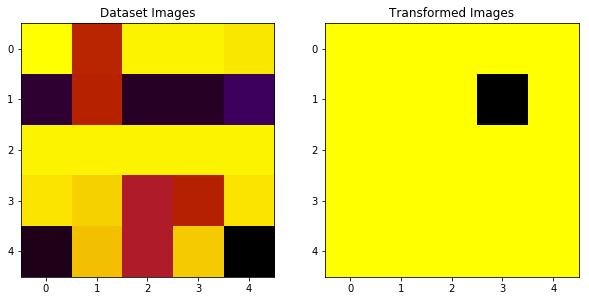

In [0]:
def visualize_tile():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(train_loader))[0].to(device)
      
        input_tensor = data.cpu()
        
        transformed_input_tensor = model.RecNet(data).cpu()
        

        in_grid = convert_image_np(
            input_tensor)
        print(in_grid.shape)

        out_grid = convert_image_np(
            transformed_input_tensor)
        print(out_grid.shape)

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2,figsize=(10,10))
        axarr[0].imshow(in_grid[0,0,:,:],cmap='gnuplot')
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid[0,0,:,:],cmap='gnuplot')
        axarr[1].set_title('Transformed Images')

visualize_tile()

plt.ioff()
plt.show()

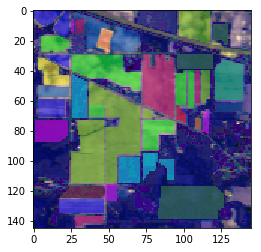

In [0]:
import spectral
data_url , label_url = 'Indian_pines_corrected.mat' ,'Indian_pines_gt.mat'
X = np.array(scipy.io.loadmat('/content/'+data_url.split('/')[-1])[data_url.split('/')[-1].split('.')[0].lower()])
y = np.array(scipy.io.loadmat('/content/'+label_url.split('/')[-1])[label_url.split('/')[-1].split('.')[0].lower()])
view = spectral.imshow(X,(30,20,100), classes=y)
view.set_display_mode('overlay')
view.class_alpha = 0.5

In [0]:
X.shape, y.shape

((145, 145, 200), (145, 145))